# Haematopoiesis dataset

The original data in this example is from the following article:

Valérie Marot-Lassauzaie, Brigitte Joanne Bouman, et al. Towards reliable quantification of cell state velocities bioRxiv (2022)

See Github repo https://github.com/HaghverdiLab/velocity_notebooks

For details of the preprocessing (namely, how `P_kappavelo.npy` was obtained), see https://github.com/zsteve/locaTE-paper/tree/main/examples/HSPC

In [5]:
import anndata as ad
import scvelo as scv
import pandas as pd
import os
import numpy as np
import scanpy as sc
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
DATA_DIR = "data/"

Load data, filter and preprocess

In [6]:
adata = ad.read_h5ad(os.path.join(DATA_DIR, "anndata_raw.h5ad"))
adata.obs["pseudotime"] = np.load(os.path.join(DATA_DIR, "pseudotime.npy"))
adata.uns["celltypes_colors"] = pd.read_csv(os.path.join(DATA_DIR, "celltypes_colors.csv"), header=None).iloc[:,0].values
adata.obsm["X_umap"] = pd.read_csv(os.path.join(DATA_DIR, "UMAP_coordinates.csv"), header = 0, index_col = 0).values
adata.obsm["X_umap_original"] = pd.read_csv(os.path.join(DATA_DIR, "original_UMAP.csv"), header = None).values
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)

Filtered out 18125 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

2023-04-03 11:30:09.723293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 11:30:09.844559: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 11:30:10.756440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: $LD_LIBRARY_PATH:/data/gpfs/projects/punim0638/stephenz/envs/unitvelo/lib/
2023-04-03 1

Fetch TF list from AnimalTFDB3 

In [8]:
!wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF -P data/

--2023-04-03 11:30:14--  http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF
Resolving bioinfo.life.hust.edu.cn (bioinfo.life.hust.edu.cn)... 222.20.95.101
Connecting to bioinfo.life.hust.edu.cn (bioinfo.life.hust.edu.cn)|222.20.95.101|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159032 (155K)
Saving to: ‘data/Mus_musculus_TF.1’

100%[======================================>] 159,032      233KB/s   in 0.7s   

2023-04-03 11:30:15 (233 KB/s) - ‘data/Mus_musculus_TF.1’ saved [159032/159032]



In [9]:
df = pd.read_csv(os.path.join(DATA_DIR, "Mus_musculus_TF"), sep = "\t")
adata.var['istf'] = np.isin(adata.var.index.str.lower(), df.Symbol.str.lower())

In [10]:
# construct cell-cell distances from kNN graph
G_sp = adata.uns['neighbors']['distances']
adata.obsm["C"] = sp.sparse.csgraph.floyd_warshall(G_sp, directed = False)**2
# calculate neighbourhood kernel using QOT
import ot
adata.obsm["R"] = ot.smooth.smooth_ot_dual(np.ones(adata.shape[0]), np.ones(adata.shape[0]), adata.obsm["C"], 2.5*adata.obsm["C"].mean())

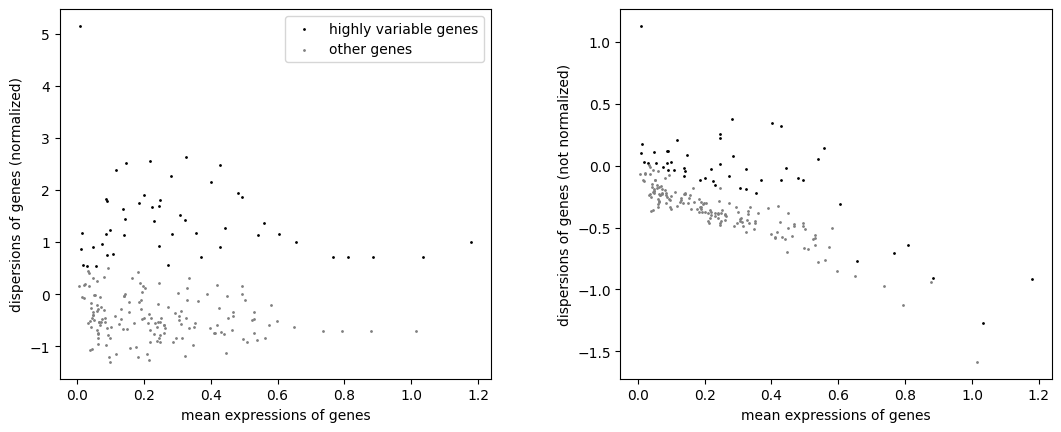

In [11]:
adata_subset = adata.copy()
sc.pp.log1p(adata_subset)
adata_subset = adata_subset[:, adata_subset.var.istf]
# subset out 50 variable TFs
N_hvg = 50
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = False)
sc.pl.highly_variable_genes(adata_subset)
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = True)

In [42]:
np.save(os.path.join(DATA_DIR, "X.npy"), adata_subset.X[:, adata_subset.var.istf].todense())
np.save(os.path.join(DATA_DIR, "X_pca.npy"), adata_subset.obsm["X_pca"])
np.save(os.path.join(DATA_DIR, "X_umap.npy"), adata_subset.obsm["X_umap"])
np.save(os.path.join(DATA_DIR, "R.npy"), adata.obsm["R"])

In [47]:
!julia ../../src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --outdir locaTE_output --gpu $DATA_DIR/X.npy $DATA_DIR/X_pca.npy $DATA_DIR/P_kappavelo.npy $DATA_DIR/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17K
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
[ Info: ΔX = 4.422940708245864e-9, ΔZ = 4.1569307273128797e-7, ΔW = 1.0175569029637066e-6
[ Info: tr(X'LX) = 1.9887138934951216, 0.5|X-G|^2 = 4.220826639530922, |X|1 = 7369.472947943585


In [48]:
adata_subset.write_h5ad(os.path.join(DATA_DIR, "adata_subset_tf.h5ad"))